# **Sentiment Analysis with Naive Bayes and Logistic Regression**

## **Preparing Dependencies**

**Download Dependencies**

In [2]:
#!pip install openpyxl
#!pip -q install sastrawi

**Import Dependencies**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import re
import seaborn as sn
import nltk


from tqdm.notebook import tqdm
from tqdm import tqdm

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [ ]:
# download Stopwords bahasa indonesia
nltk.download('stopwords')

## **Load Dataset**

In [ ]:
# membaca data dari file csv dengan menyertakan parameter delimeter
df = pd.read_excel('dataset/fix_dataset.xlsx')
df.head()

In [ ]:
data = df[['comment', 'Labeling']]
data = data.iloc[1:,:]
data.head()

## **Preprocessing**

### **Casefolding**

In [ ]:
# Fungsi casefolding
def casefolding(text):
    if isinstance(text, str):  # Pastikan hanya string yang diproses
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Menghapus karakter non-alphabet
    return text

# Terapkan casefolding dengan memastikan setiap nilai diubah menjadi string
data["casefolding"] = data["comment"].apply(lambda x: casefolding(str(x)))

# Tampilkan data
data.head()


### **Normalisasi Kata**

In [ ]:
key_norm = pd.read_csv('dataset/key_norm.csv')

def text_normalize(text):
    
    text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
    text = str.lower(text)
    
    return text

data['textnormalize'] = data['casefolding'].apply(text_normalize)
data.head()

### **Stopwords Removal**

In [ ]:
stopwords_ind = stopwords.words('indonesian')
stopwords_ind

In [10]:
# Membuat DataFrame dari daftar stopwords
stopwords_df = pd.DataFrame(stopwords_ind, columns=['stopwords'])

# Menyimpan DataFrame ke dalam file CSV
stopwords_df.to_csv('stopwords_indonesian.csv', index=False)

In [ ]:
def remove_stop_words(text):
    clean_words = []
    text = text.split()
    for word in text:
        if word not in stopwords_ind:
            clean_words.append(word)
            
    return " ".join(clean_words)

data['stopwordremoval'] = data['textnormalize'].apply(remove_stop_words)
data.head()

### **Stemming**

In [ ]:
# Set up the stemming factory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
    return stemmer.stem(text)

# Tambahkan support untuk tqdm pada pandas
tqdm.pandas()

# Terapkan stemming dengan tqdm untuk melihat progress
data['stemming'] = data['stopwordremoval'].progress_apply(stemming)

# Lihat hasilnya
data.head()

In [ ]:
data["clean_text"] = data['stemming']

data.drop(["casefolding","textnormalize","stopwordremoval","stemming"],axis=1,inplace=True)
data.head()

### **Other Cleaning**

In [ ]:
data = data[data["clean_text"]!=""]
data

In [ ]:
data['Labeling'].value_counts()

In [ ]:
data = data[data['Labeling'] != 'netral']
data

## **Visualization**

**Plot Sentimen tiap Channel**

In [ ]:
sentimen_tiap_channel = pd.pivot_table(index = 'nama_channel', columns = 'Labeling', aggfunc = 'size', data = df, fill_value = 0)

sentimen_tiap_channel.plot(kind = 'bar')

**WordCloud Tiap Sentimen**

In [18]:
from wordcloud import WordCloud

In [19]:
def word_cloud_from_sentimen(data, sentimen) :
    sentimen_data = data[data['Labeling'] == sentimen]
    
    sentimen_text = ' '.join(sentimen_data["clean_text"].values.tolist())
    
    wordcloud_sentimen = WordCloud(width  = 800, 
                                   height = 800,
                                   background_color = 'white',
                                   stopwords = None,
                                   min_font_size = 10).generate(sentimen_text)
    
    plt.figure(figsize=(16, 9))
    plt.imshow(wordcloud_sentimen, interpolation='bilinear')
    plt.title(f'Sentimen {sentimen.title()}')
    plt.axis('off')
    plt.show()

In [ ]:
word_cloud_from_sentimen(data, 'positif')

In [ ]:
word_cloud_from_sentimen(data, 'negatif')

## **Splitting Data**

In [22]:
X_raw = data["clean_text"]
y_raw = data["Labeling"]

#memisahkan menjadi 2 bagian yaitu 20% data uji 80% data latih
X_train, X_test, y_train, y_test = train_test_split(X_raw.values, y_raw.values, test_size = 0.2, random_state=42, stratify = y_raw)

## **Feature Extraction**

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(X_train)

In [ ]:
X_train_TFIDF = vectorizer.transform(X_train).toarray()
X_test_TFIDF  = vectorizer.transform(X_test).toarray() 

X = vectorizer.transform(data["clean_text"]).toarray()

kolom = vectorizer.get_feature_names_out()

train_tf_idf = pd.DataFrame(X_train_TFIDF, columns=kolom)
test_tf_idf  = pd.DataFrame(X_test_TFIDF,  columns=kolom)
train_tf_idf.head()

**Plot TF-IDF**

In [25]:
colors = sn.color_palette("viridis", n_colors = 3)

- **Top 10 Kata Kunci dengan Nilai Rata-rata TF-IDF (Data Training)**

In [ ]:
mean_tfidf = train_tf_idf.mean().sort_values(ascending=False).head(10)

fig, ax = plt.subplots()

ax.bar(mean_tfidf.index, mean_tfidf.values, color = colors)
ax.set_ylabel('Rata-rata Nilai TF-IDF')

plt.xticks(rotation = 45) ;

- **Top 10 Kata Kunci dengan Nilai Rata-rata TF-IDF (Data Testing)**

In [ ]:
mean_tfidf = test_tf_idf.mean().sort_values(ascending=False).head(10)

fig, ax = plt.subplots()
    
ax.bar(mean_tfidf.index, mean_tfidf.values, color = colors)
ax.set_ylabel('Rata-rata Nilai TF-IDF')
plt.xticks(rotation = 45) ; 

## **Feature Selection**

### **Feature Selection dengan k = 500**

In [ ]:
chi2_500_features   = SelectKBest(chi2, k = 500)

X_500_best_features = chi2_500_features.fit_transform(train_tf_idf, y_train)

print('Banyaknya fitur awal:', train_tf_idf.shape[1])
print('banyaknya fitur setelah di seleksi:', X_500_best_features.shape[1])


In [29]:
selected_500_feature_names = [kolom[i] for i in chi2_500_features.get_support(indices=True)]

# Create a DataFrame with the selected features
selected_500_train_tf_idf = pd.DataFrame(X_500_best_features, columns = selected_500_feature_names)

# Save the DataFrame to an Excel file
selected_500_train_tf_idf.to_excel('selected_TF_IDF_500_features_sastrawi.xlsx', index=False)

### **Feature Selection with k in range (501-2000)**

In [48]:
def model_performance_with_feature_selection_with_k_feature(start, end, model_) :
    
    k_feature_acc , k_feature_f1 , max_acc , max_f1 = [0, 0, 0, 0]

    k = []
    acc = []
    f1 = []

    # Loop untuk memilih fitur terbaik dan menghitung skor
    for feature in tqdm(range(start, end + 1)) :
        
        chi2_features = SelectKBest(chi2, k = feature)
        X_kbest_features = chi2_features.fit_transform(train_tf_idf.values, y_train)
        
        model = model_

        model.fit(X_kbest_features, y_train)

        # Transformasi data uji menggunakan chi2_features
        X_test_ch2 = chi2_features.transform(X_test_TFIDF)

        # Prediksi label untuk data uji
        y_pred = model.predict(X_test_ch2)

        # Hitung akurasi dan F1-Score
        acc_temp = accuracy_score(y_test, y_pred)
        f1_temp  = f1_score(y_test, y_pred, average = "weighted")

        k.append(feature)
        acc.append(acc_temp)
        f1.append(f1_temp)

        # Update hasil terbaik jika ditemukan skor yang lebih tinggi
        if max_acc < acc_temp:
            max_acc = acc_temp
            k_feature_acc = feature
            
        if max_f1 < f1_temp:
            max_f1 = f1_temp
            k_feature_f1 = feature

    hasil = {'max_accuracy' : max_acc,
             'max_f1_score' : max_f1,  
             'k_feature_acc': k_feature_acc,
             'k_feature_f1' : k_feature_f1,
             'k_history'    : k,
             'acc_history'  : acc, 
             'f1_history'   : f1}
    
    return hasil

## **Modelling**

#### **Support Function**

In [31]:
def confusion_matrix_plot(y_test, y_pred) :
    kolom = ['negatif', 'positif']

    confm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(confm, index = kolom, columns=kolom)

    ax = sn.heatmap(df_cm, cmap='Greens', annot=True, fmt=".0f")

    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Sentimen Sebenarnya')
    ax.set_ylabel('Sentimen Prediksi')

    ax.invert_xaxis()

    plt.show()

In [55]:
def k_features_performance_plot(k, acc, f1) :
    fig, ax = plt.subplots(2, 1)

    ax[0].plot(k, acc, color = 'red')
    ax[0 ].set_title('Accuracy dari setiap k-feature')

    ax[1].plot(k, f1)
    ax[1].set_title('F1-Score dari setiap k-feature')

    plt.tight_layout()

    plt.show()

### **Gaussian Naive Bayes**

#### **All Features**

- **Preparing Model**

In [ ]:
gnb_all_features = GaussianNB()
gnb_all_features.fit(X_train_TFIDF, y_train)

- **Classification Report**

In [ ]:
y_pred_gnb_all  = gnb_all_features.predict(X_test_TFIDF)

print(classification_report(y_test, y_pred_gnb_all))

- **Confusion Matrix Heatmap**

In [ ]:
confusion_matrix_plot(y_test, y_pred_gnb_all)

#### **With 500 Features**

- **Preparing Model**

In [ ]:
gnb_500 = GaussianNB()
gnb_500.fit(X_500_best_features, y_train)

- **Classification Report**

In [ ]:
X_test_gnb_500 = chi2_500_features.transform(X_test_TFIDF)
y_pred_gnb_500 = gnb_500.predict(X_test_gnb_500)

print(classification_report(y_test, y_pred_gnb_500))

- **Confusion Matrix Heatmap**


In [ ]:
confusion_matrix_plot(y_test, y_pred_gnb_500)

#### **Eksperimen Feature Selection dengan 10-2000 Feature**

- **Performance**  

In [ ]:
k_gnb_performance = model_performance_with_feature_selection_with_k_feature(model_ = GaussianNB(), start = 501, end = 2000)

k_gnb_max_acc     = k_gnb_performance['max_accuracy']
k_gnb_max_f1      = k_gnb_performance['max_f1_score']
k_gnb_k_history   = k_gnb_performance['k_history']
k_gnb_acc_history = k_gnb_performance['acc_history']
k_gnb_f1_history  = k_gnb_performance['f1_history']

k_gnb_num_feature_acc = k_gnb_performance['k_feature_acc']
k_gnb_num_feature_f1  = k_gnb_performance['k_feature_f1']

In [ ]:
print(f"Accuracy terbaik adalah {k_gnb_max_acc} dengan banyaknya fitur {k_gnb_num_feature_acc}")
print(f"F1-Score terbaik adalah {k_gnb_max_f1} dengan banyaknya fitur  {k_gnb_num_feature_f1}")

- **Plot Accuracy dan F1-Score tiap K-Feature**

In [ ]:
k_features_performance_plot(k_gnb_k_history, k_gnb_acc_history, k_gnb_f1_history)

- **Feature Selection dengan K = 1992 (Hasil Eksperimen)**

In [ ]:
chi2_features = SelectKBest(chi2, k = k_gnb_num_feature_f1)
X_kbest_gnb_features = chi2_features.fit_transform(train_tf_idf.values, y_train)

print('Banyaknya fitur awal:', train_tf_idf.shape[1])
print('Banyaknya fitur setelah diseleksi:', X_kbest_gnb_features.shape[1])

- **Classification Report**

In [ ]:
k_gnb = GaussianNB()
k_gnb.fit(X_kbest_gnb_features, y_train)

X_test_ch2 = chi2_features.transform(X_test_TFIDF)

# Prediksi label untuk data uji
y_pred_k_gnb = k_gnb.predict(X_test_ch2)

accuracy_k_gnb = accuracy_score(y_test, y_pred_k_gnb)

print(classification_report(y_test, y_pred_k_gnb))

- **Confusion Matrix Heatmap**

In [ ]:
confusion_matrix_plot(y_test, y_pred_k_gnb)

### **Logistic Regression**

#### **All Features**

- **Preparing Model**

In [ ]:
lr_all_features = LogisticRegression(C = 10.0, fit_intercept = False)
lr_all_features.fit(X_train_TFIDF, y_train)

- **Classification Report**

In [ ]:
y_pred_lr_all = lr_all_features.predict(X_test_TFIDF)

print(classification_report(y_test, y_pred_lr_all))

- **Confusion Matrix Heatmap**

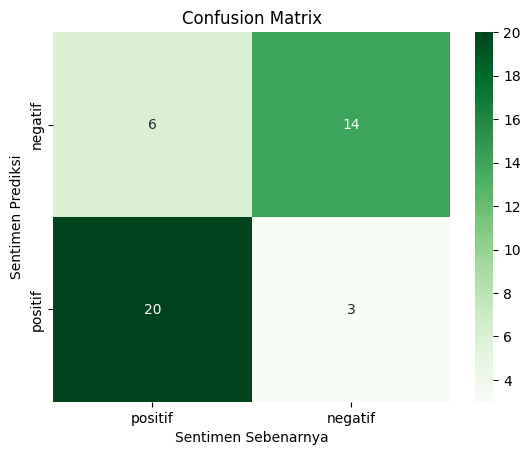

In [64]:
confusion_matrix_plot(y_test, y_pred_lr_all)

#### **With 500 Features**

- **Preparing Model**

In [ ]:
lr_500 = LogisticRegression(C = 10.0, fit_intercept = False)
lr_500.fit(X_500_best_features, y_train)

- **Classification Report**

In [ ]:
X_test_lr_500 = chi2_500_features.transform(X_test_TFIDF)
y_pred_lr_500 = lr_500.predict(X_test_lr_500)

print(classification_report(y_test, y_pred_lr_500))

- **Confusion Matrix Heatmap**

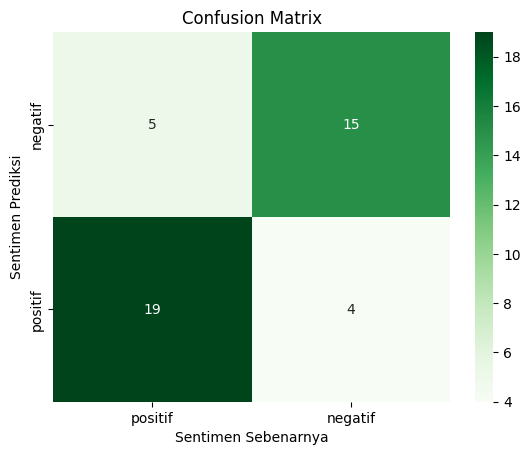

In [65]:
confusion_matrix_plot(y_test, y_pred_lr_500)

#### **Eksperimen Feature Selection dengan 10-2000 Feature**

- **Performance**  


In [ ]:
k_lr_performance = model_performance_with_feature_selection_with_k_feature(model_ = LogisticRegression(C = 10.0, fit_intercept = False), start = 501, end = 2000)

k_lr_max_acc     = k_lr_performance['max_accuracy']
k_lr_max_f1      = k_lr_performance['max_f1_score']
k_lr_k_history   = k_lr_performance['k_history']
k_lr_acc_history = k_lr_performance['acc_history']
k_lr_f1_history  = k_lr_performance['f1_history']

k_lr_num_feature_acc = k_lr_performance['k_feature_acc']
k_lr_num_feature_f1  = k_lr_performance['k_feature_f1']

In [ ]:
print(f"Accuracy terbaik adalah {k_lr_max_acc} dengan banyaknya fitur {k_lr_num_feature_acc}")
print(f"F1-Score terbaik adalah {k_lr_max_f1} dengan banyaknya fitur  {k_lr_num_feature_f1}")

- **Plot Accuracy dan F1-Score tiap K-Feature**

In [ ]:
k_features_performance_plot(k_lr_k_history, k_lr_acc_history, k_lr_f1_history)

- **Feature Selection dengan K = 1543 (Hasil Eksperimen)**

In [ ]:
chi2_features = SelectKBest(chi2, k = k_lr_num_feature_f1)
X_kbest_lr_features = chi2_features.fit_transform(train_tf_idf.values, y_train)

print('Banyaknya fitur awal:', train_tf_idf.shape[1])
print('Banyaknya fitur setelah diseleksi:', X_kbest_lr_features.shape[1])

- **Classification Report**

In [ ]:
k_lr = LogisticRegression(C = 10.0, fit_intercept = False)
k_lr.fit(X_kbest_lr_features, y_train)

X_test_ch2 = chi2_features.transform(X_test_TFIDF)

# Prediksi label untuk data uji
y_pred_k_lr = k_lr.predict(X_test_ch2)

accuracy_k_lr = accuracy_score(y_test, y_pred_k_lr)

print(classification_report(y_test, y_pred_k_lr))

- **Confusion Matrix Heatmap**

In [ ]:
confusion_matrix_plot(y_test, y_pred_k_lr)